# Regional Effects (known black-box function)

This tutorial provides a gentle overview of Regional Effect methods and introduces the `Effector` package. Regional Effects serve as a bridge between local and global feature effects. Αs shown in [REPID](https://proceedings.mlr.press/v151/herbinger22a/herbinger22a.pdf), regional effect methods split the feature space in subregions where the feature interactions are minimized.

In this tutorial, we show how to use `Effector` to explain a black box function using regional effect plots. The tutorial is organized as follows:

- Introduction of the simulation example, using two datasets, one with uncorrelated and the other with correlated features. 
- Examine how PDP/RHALE/SHAP plots model the feature effect and how their regional counterpart can minimize feature interactions, providing better explanations.
- Show how each of these methods behaves under correlated and uncorrelated features.

In [1]:
import numpy as np
import effector

## Simulation example

### Data Generating Distribution

We will generate $N=1000$ examples with $D=3$ features, which are uniformly distributed as follows:

<center>

| Feature | Description                                | Distribution                 |
|-------|------------------------------------------|------------------------------|
| $x_1$   | Uniformly distributed between $-1$ and $1$ | $x_1 \sim \mathcal{U}(-1,1)$ |
| $x_2$   | Uniformly distributed between $-1$ and $1$ | $x_2 \sim \mathcal{U}(-1,1)$ |
| $x_3$   | Uniformly distributed between $-1$ and $1$ | $x_3 \sim \mathcal{U}(-1,1)$ |

</center>

For the correlated setting we keep the distributional assumptions for $x_2$ and $x_3$ but define $x_1$ such that it is identical to $x_3$ by: $x_1 = x_3$.

In [2]:
def generate_dataset_uncorrelated(N):
    x1 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x3 = np.random.uniform(-1, 1, size=N)
    return np.stack((x1, x2, x3), axis=-1)

def generate_dataset_correlated(N):
    x3 = np.random.uniform(-1, 1, size=N)
    x2 = np.random.uniform(-1, 1, size=N)
    x1 = x3
    return np.stack((x1, x2, x3), axis=-1)

# generate the dataset for the uncorrelated and correlated setting
N = 1000
X_uncor_train = generate_dataset_uncorrelated(N)
X_uncor_test = generate_dataset_uncorrelated(10000)
X_cor_train = generate_dataset_correlated(N)
X_cor_test = generate_dataset_correlated(10000)

### Black-box function

We will use the following linear model with a subgroup-specific interaction term:
 $$ y = 3x_1I_{x_3>0} - 3x_1I_{x_3\leq0} + x_3$$ 
 
On a global level, there is a high heterogeneity for the features $x_1$ and $x_3$ due to their interaction with each other. However, this heterogeneity vanishes to 0 if the feature space is separated into subregions:

<center>

| Feature | Region      | Average Effect | Heterogeneity |
|---------|-------------|----------------|---------------|
| $x_1$   | $x_3>0$     | $3x_1$         | 0             |
| $x_1$   | $x_3\leq 0$ | $-3x_1$        | 0             |
| $x_2$   | all         | 0              | 0             |
| $x_3$   | $x_3>0$     | $x_3$          | 0             |
| $x_3$   | $x_3\leq 0$ | $x_3$          | 0             |

</center>

In [3]:
def model(x):
    f = np.where(x[:,2] > 0, 3*x[:,0] + x[:,2], -3*x[:,0] + x[:,2])
    return f

def model_jac(x):
    dy_dx = np.zeros_like(x)
    
    ind1 = x[:, 2] > 0
    ind2 = x[:, 2] <= 0
    
    dy_dx[ind1, 0] = 3
    dy_dx[ind2, 0] = -3
    dy_dx[:, 2] = 1
    return dy_dx


In [4]:
Y_uncor_train = model(X_uncor_train)
Y_uncor_test = model(X_uncor_test)
Y_cor_train = model(X_cor_train)
Y_cor_test = model(X_cor_test)      

---
## PDP

The PDP is defined as **_the average of the model's output over the entire dataset, while varying the feature of interest._**:

$$ \text{PDP}(x_s) = \mathbb{E}_{x_c}[f(x_s, x_c)] $$ 

and is approximated using the training data: 

$$ \hat{\text{PDP}}(x_s) = \frac{1}{N} \sum_{j=1}^N f(x_s, x^{(i)}_c) =  \frac{1}{N} \sum_{j=1}^N ICE^i(x_s)$$

The PDP is simply the average over the underlying ICE curves (local effects). The ICE curves show how the feature of interest influences the prediction of the ML model *for each single instance*. The ICE curves show the heterogeneity of the local effects.

### Uncorrelated setting

#### Global PDP

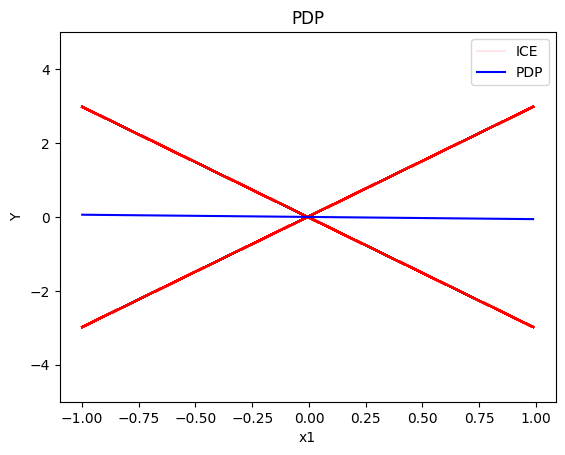

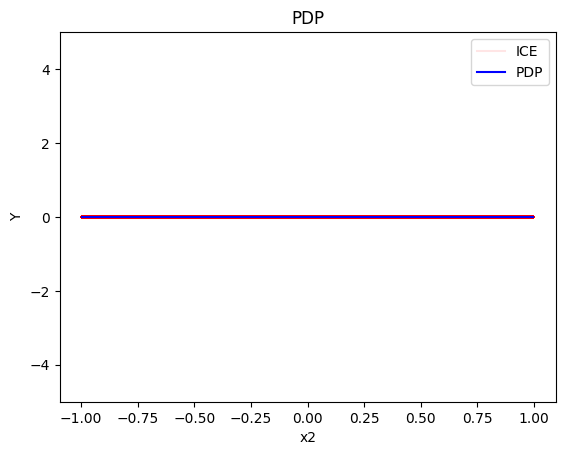

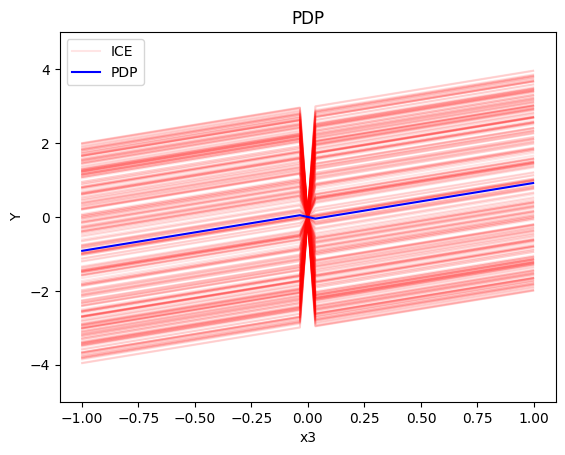

In [5]:
pdp = effector.PDP(data=X_uncor_train, model=model, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])

#### Regional PDP

Regional PDP will search for explanations that minimize the interaction-related heterogeneity.

In [6]:
regional_pdp = effector.RegionalPDP(data=X_uncor_train, model=model, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
regional_pdp.fit(features="all", heter_pcg_drop_thres=0.3, nof_candidate_splits_for_numerical=11)

100%|██████████| 3/3 [00:00<00:00, 27.85it/s]


In [7]:
regional_pdp.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 1.74 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= -0.0, heter: 0.28 || nof_instances:   496 || weight: 0.50
        Node id: 2, name: x1 | x3  > -0.0, heter: 0.29 || nof_instances:   504 || weight: 0.50
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 1.74
        Level 1, heter: 0.29 || heter drop: 1.45 (83.59%)


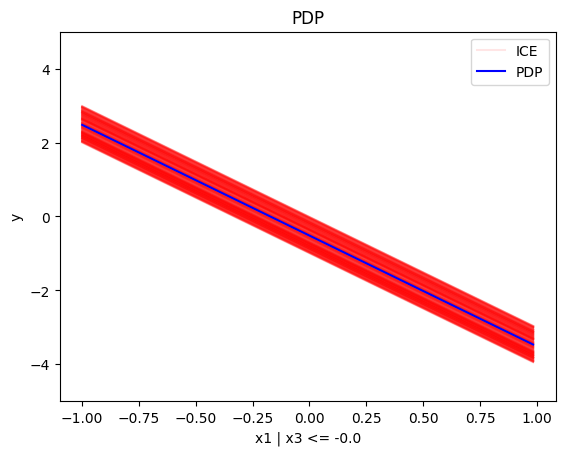

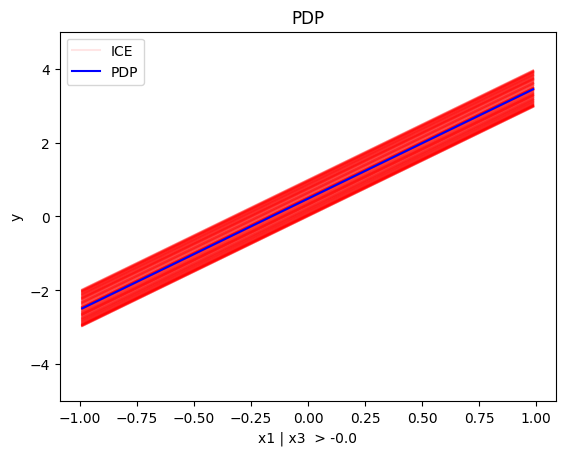

In [8]:
regional_pdp.plot(feature=0, node_idx=1, heterogeneity="ice", y_limits=[-5, 5])
regional_pdp.plot(feature=0, node_idx=2, heterogeneity="ice", y_limits=[-5, 5])

In [9]:
regional_pdp.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 1.84 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 1.84


In [10]:
regional_pdp.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 1.75 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x3 | x1 <= -0.0, heter: 0.86 || nof_instances:   489 || weight: 0.49
        Node id: 2, name: x3 | x1  > -0.0, heter: 0.86 || nof_instances:   511 || weight: 0.51
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 1.75
        Level 1, heter: 0.86 || heter drop: 0.89 (51.06%)


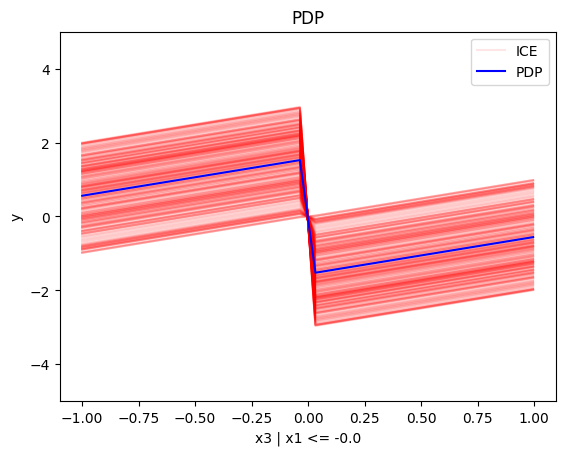

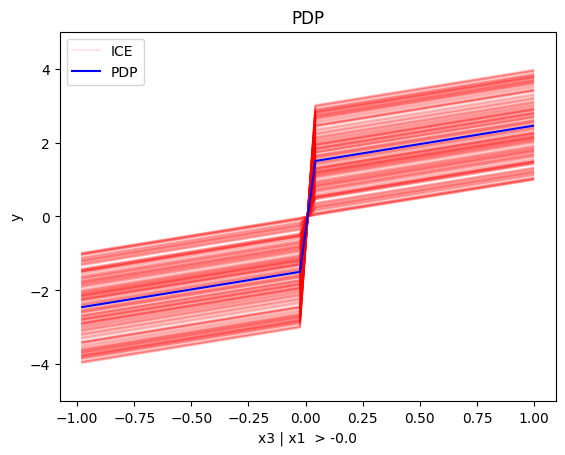

In [11]:
regional_pdp.plot(feature=2, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=2, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

#### Conclusion

For the Global PDP:

   * the average effect of $x_1$ is $0$ with some heterogeneity implied by the interaction with $x_1$. The heterogeneity is expressed with two opposite lines; $-3x_1$ when $x_1 \leq 0$ and $3x_1$ when $x_1 >0$
   * the average effect of $x_2$ to be $0$ without heterogeneity
   * the average effect of $x_3$ to be $x_3$ with some heterogeneity due to the interaction with $x_1$. The heterogeneity is expressed with a discontinuity around $x_3=0$, with either a positive or a negative offset depending on the value of $x_1^i$

--- 

For the Regional PDP:

* For $x_1$, the algorithm finds two regions, one for $x_3 \leq 0$ and one for $x_3 > 0$
  * when $x_3>0$ the effect is $3x_1$
  * when $x_3 \leq 0$, the effect is $-3x_1$
* For $x_2$ the algorithm does not find any subregion 
* For $x_3$, there is a change in the offset:
  * when $x_1>0$ the line is $x_3 - 3x_1^i$ in the first half and $x_3 + 3x_1^i$ later
  * when $x_1<0$ the line is $x_3 + 3x_1^i$ in the first half and $x_3 - 3x_1^i$ later

### Correlated setting

PDP assumes feature independence, therefore, it is *not* a good explanation method for the correlated case.
Due to this face, we expect the explanations to be identical with the uncorrelated case, which is not correct as we will see later in (RH)ALE plots.

#### Global PDP

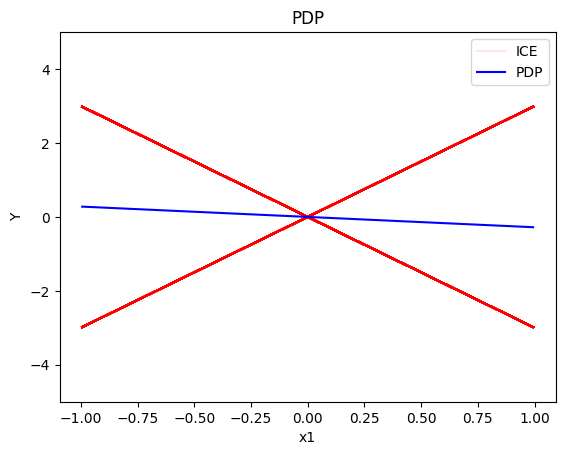

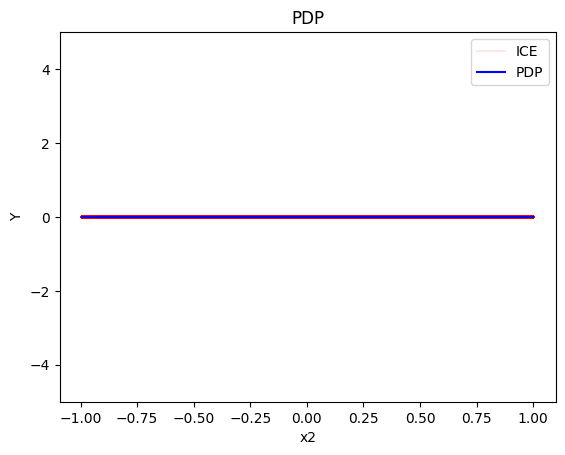

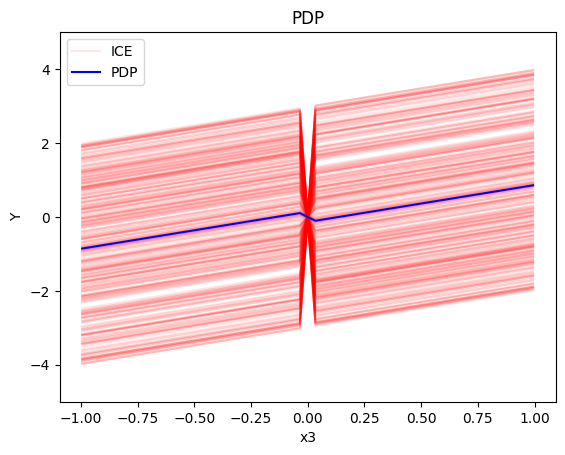

In [12]:
pdp = effector.PDP(data=X_cor_train, model=model, feature_names=['x1','x2','x3'], target_name="Y")
pdp.plot(feature=0, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=1, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])
pdp.plot(feature=2, centering=True, show_avg_output=False, heterogeneity="ice", y_limits=[-5, 5])

#### Regional-PDP

In [13]:
regional_pdp = effector.RegionalPDP(data=X_cor_train, model=model, feature_names=['x1','x2','x3'], axis_limits=np.array([[-1,1],[-1,1],[-1,1]]).T)
regional_pdp.fit(features="all", heter_pcg_drop_thres=0.4, nof_candidate_splits_for_numerical=11)

100%|██████████| 3/3 [00:00<00:00, 23.85it/s]


In [14]:
regional_pdp.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 1.74 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.0, heter: 0.29 || nof_instances:   514 || weight: 0.51
        Node id: 2, name: x1 | x3  > 0.0, heter: 0.30 || nof_instances:   486 || weight: 0.49
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 1.74
        Level 1, heter: 0.29 || heter drop: 1.45 (83.23%)


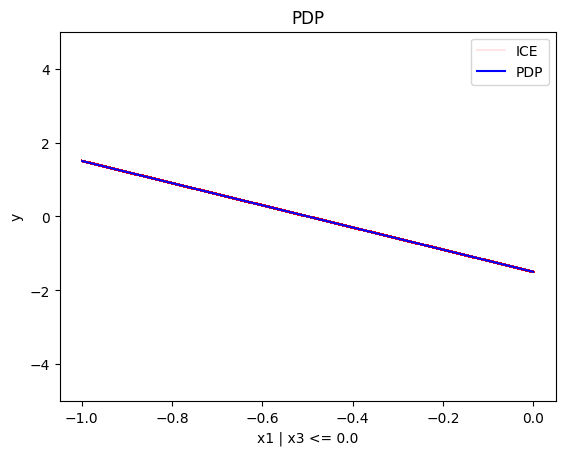

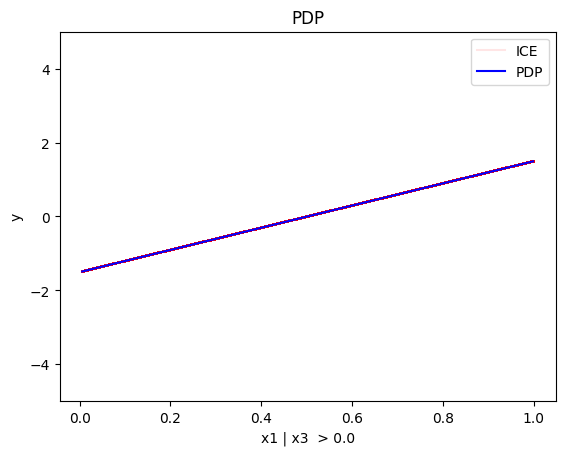

In [15]:
regional_pdp.plot(feature=0, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=0, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

In [16]:
regional_pdp.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 1.04 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x2 | x1 <= 0.54, heter: 0.59 || nof_instances:   783 || weight: 0.78
        Node id: 2, name: x2 | x1  > 0.54, heter: 0.54 || nof_instances:   217 || weight: 0.22
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 1.04
        Level 1, heter: 0.58 || heter drop: 0.46 (44.15%)


In [17]:
regional_pdp.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 1.75 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x3 | x1 <= 0.0, heter: 0.86 || nof_instances:   514 || weight: 0.51
        Node id: 2, name: x3 | x1  > 0.0, heter: 0.89 || nof_instances:   486 || weight: 0.49
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 1.75
        Level 1, heter: 0.88 || heter drop: 0.87 (49.77%)


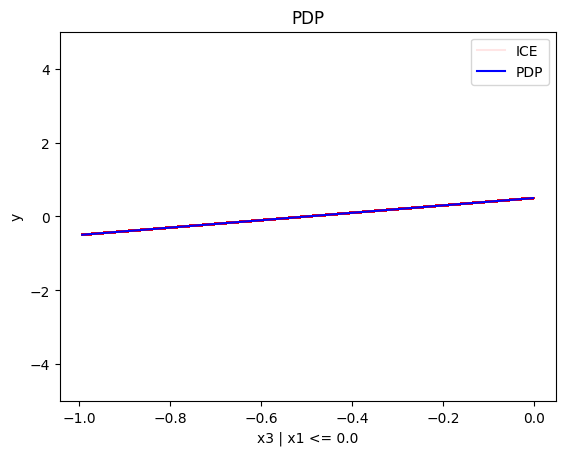

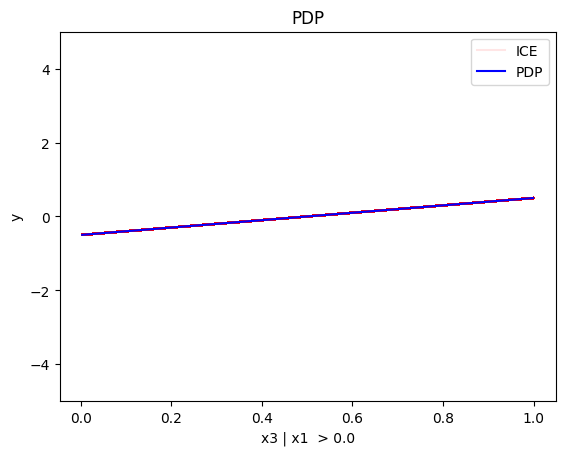

In [18]:
regional_pdp.plot(feature=2, node_idx=1, heterogeneity="ice", centering=True, y_limits=[-5, 5])
regional_pdp.plot(feature=2, node_idx=2, heterogeneity="ice", centering=True, y_limits=[-5, 5])

#### Conclusion

As expected, the global and the regional PDP explanations are identical with the uncorrelated case.

## (RH)ALE

(RH)ALE defines the feature effect as *the integral of the partial derivative of the model's output with respect to the feature of interest*:

$$\text{ALE}(x_s) = \int_{z=0}^{x_s} \mathbb{E}_{x_c|x_s=z}\left [ \frac{\partial f}{\partial x_s} (z, x_c) \right ] \partial z$$

The approximation is defined as:

$$\hat{\text{ALE}}(x_s) = \sum_{k=1}^{k_{x_s}} \frac{1}{| \mathcal{S}_k |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \left [ f(z_k, x_c) - f(z_{k-1}, x_c) \right ]$$

$\hat{\text{ALE}}(x_s)$ uses a Riemannian sum to approximate the integral of $\text{ALE}(x_s)$. The axis of the $s$-th feature is split in $K$ bins (intervals) of equal size. In each bin, the average effect of the feature of interest is estimated using the instances that fall in the bin. The average effect in each bin is called bin-effect. 

Robust and Heterogeneity-aware ALE (RHALE) is a variant of ALE, proposed by [Gkolemis et. al](https://arxiv.org/abs/2309.11193), where the local effects are computed using automatic differentiation:

$$\hat{\text{RHALE}}(x_s) = \sum_{k=1}^{k_{x_s}} \frac{1}{ \left | \mathcal{S}_k \right |} \sum_{i: x^{(i)} \in \mathcal{S}_k} \frac{\partial f}{\partial x_s} (x_s^{(i)}, x_c^{(i)})$$

 In their paper, [Gkolemis et. al](https://arxiv.org/abs/2309.11193) showed that RHALE has specific advantages over ALE: (a) it ensures on-distribution sampling (b) an unbiased estimation of the heterogeneity and (c) an optimal trade-off between bias and variance. In our example, we will use the RHALE approximation.

### Uncorrelated setting

#### Global RHALE

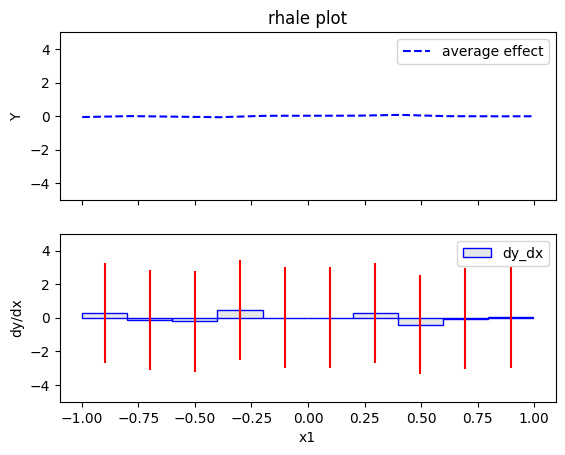

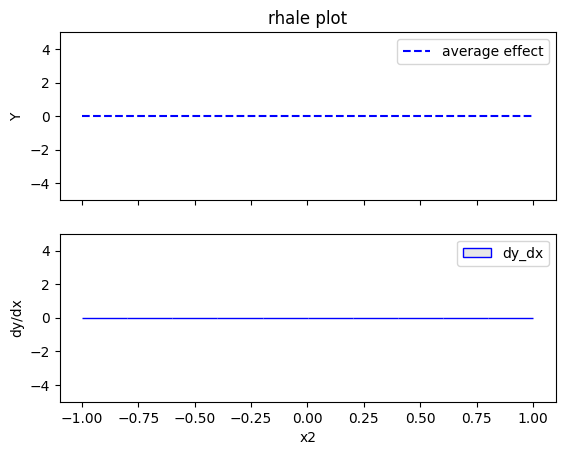

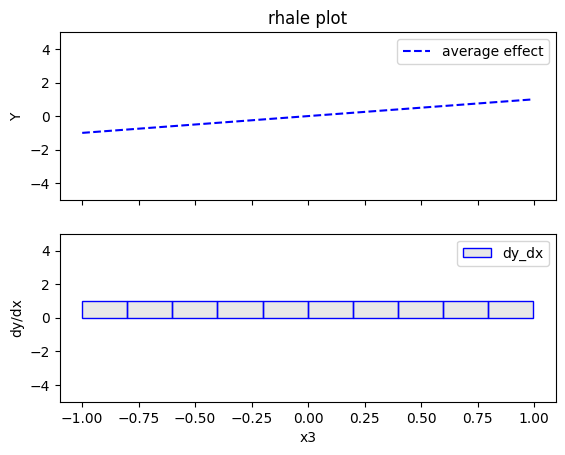

In [19]:
rhale = effector.RHALE(data=X_uncor_train, model=model, model_jac=model_jac, feature_names=['x1','x2','x3'], target_name="Y")

binning_method = effector.binning_methods.Fixed(10, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])

#### Regional RHALE

The disadvantage of RHALE plot is that it does not reveal the type of heterogeneity. Therefore, Regional (RH)ALE plots are very helpful to identify the type of heterogeneity. Let's see that in practice:

In [20]:
regional_rhale = effector.RegionalRHALE(
    data=X_uncor_train, 
    model=model, 
    model_jac= model_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.binning_methods.Fixed(11, min_points_per_bin=0)
regional_rhale.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    binning_method=binning_method,
    nof_candidate_splits_for_numerical=11
)


100%|██████████| 3/3 [00:00<00:00, 14.58it/s]


In [21]:
regional_rhale.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 5.94 || nof_instances:  1000 || weight: 1.00
        Node id: 1, name: x1 | x3 <= -0.0, heter: 0.00 || nof_instances:   496 || weight: 0.50
        Node id: 2, name: x1 | x3  > -0.0, heter: 0.00 || nof_instances:   504 || weight: 0.50
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 5.94
        Level 1, heter: 0.00 || heter drop: 5.94 (100.00%)


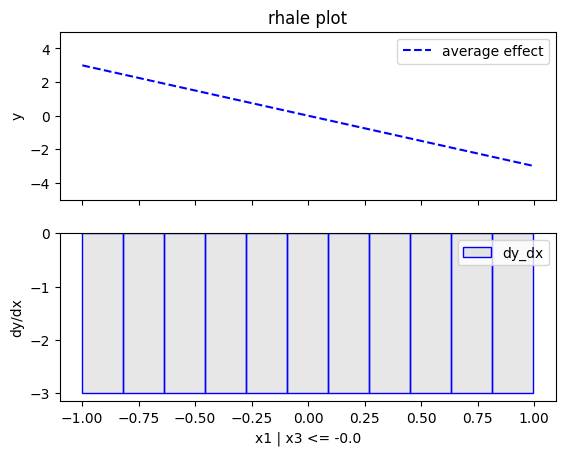

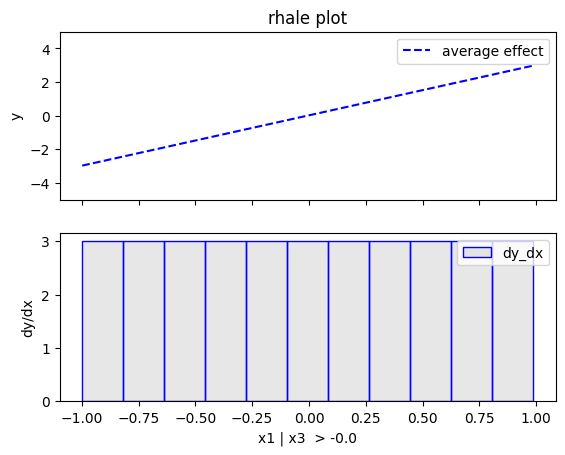

In [22]:
regional_rhale.plot(feature=0, node_idx=1, heterogeneity="std", centering=True, y_limits=[-5, 5])
regional_rhale.plot(feature=0, node_idx=2, heterogeneity="std", centering=True, y_limits=[-5, 5])

In [23]:
regional_rhale.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.00 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.00


In [24]:
regional_rhale.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.00 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.00


#### Conclusion

The explanations are similar to the ones obtained with the PDP plots. The average effect of $x_1$ is $0$ with some heterogeneity due to the interaction with $x_1$. The heterogeneity is shown with the red vertical bars. The average effect of $x_2$ is $0$ without heterogeneity. The average effect of $x_3$ is $x_3$, but in contrast with the PDP plots, there is no heterogeneity. The regional RHALE plots explain the type of the heterogeneity for $x_1$.

### Correlated setting

In the correlated setting $x_3=x_1$, therefore the model's formula becomes:

 $$ y = 3x_1I_{x_1>0} - 3x_1I_{x_1\leq0} + x_3$$ 

#### Global RHALE

RHALE plots respect feature correlations, therefore we expect the explanations to follow the formula above.

In [25]:
rhale = effector.RHALE(data=X_cor_train, model=model, model_jac=model_jac, 
                       feature_names=['x1','x2','x3'], 
                       target_name="Y", 
                       axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T)
binning_method = effector.binning_methods.Fixed(10, min_points_per_bin=0)
rhale.fit(features="all", binning_method=binning_method, centering=True)

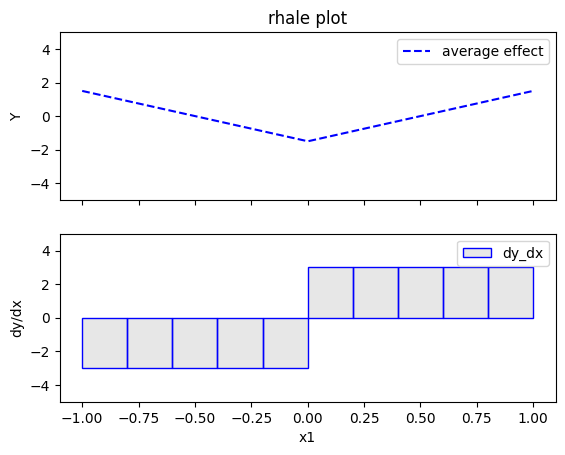

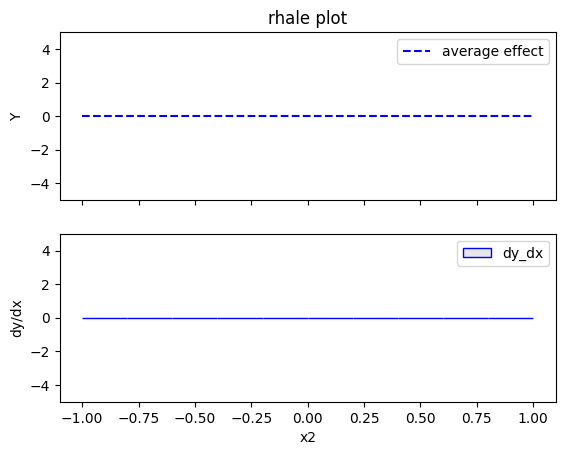

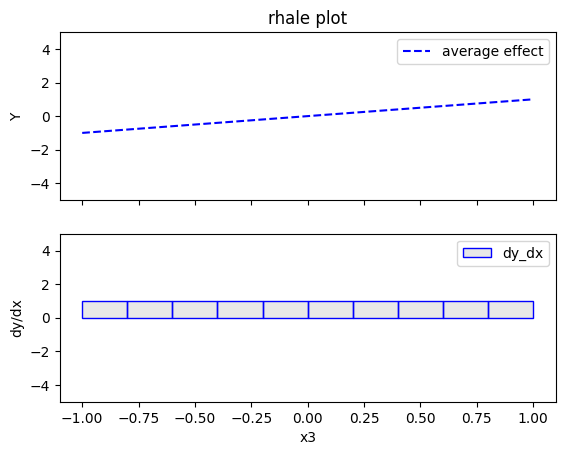

In [26]:
rhale.plot(feature=0, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=1, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])
rhale.plot(feature=2, centering=True, heterogeneity="std", show_avg_output=False, y_limits=[-5, 5], dy_limits=[-5, 5])

#### Regional RHALE

In [27]:
regional_rhale = effector.RegionalRHALE(
    data=X_cor_train, 
    model=model, 
    model_jac= model_jac, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

binning_method = effector.binning_methods.Fixed(10, min_points_per_bin=0)
regional_rhale.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    binning_method=binning_method,
    nof_candidate_splits_for_numerical=10
)


100%|██████████| 3/3 [00:00<00:00, 16.78it/s]


In [28]:
regional_rhale.show_partitioning(features=0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 0.00 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 0.00


In [29]:
regional_rhale.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.00 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.00


In [30]:
regional_rhale.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.00 || nof_instances:  1000 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.00


#### Conclusion

The global RHALE plots follow the formula obtained after setting $x_1=x_3$ while the Regional (RH)ALE plot do not find any subregions in the correlated case.

## SHAP DP

### Uncorrelated setting

#### Global SHAP DP

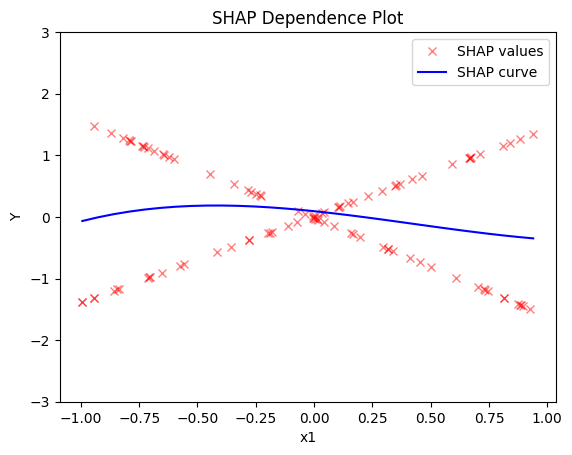

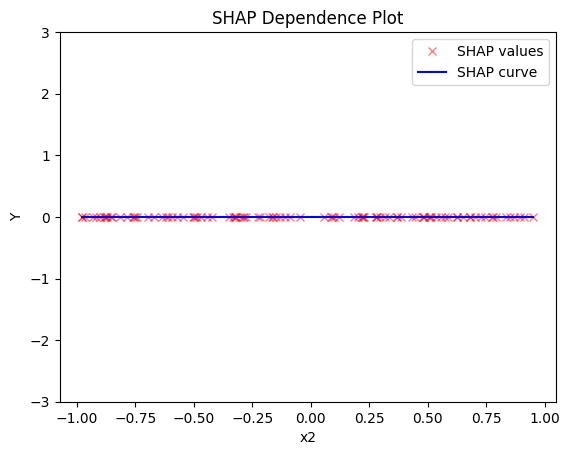

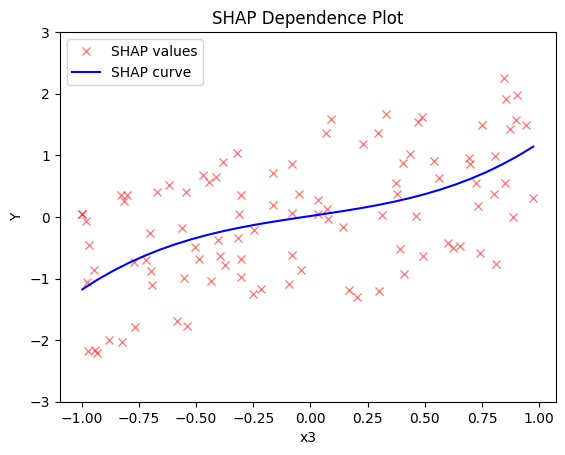

In [31]:
shap = effector.SHAPDependence(data=X_uncor_train, model=model, feature_names=['x1','x2','x3'], target_name="Y")

shap.plot(feature=0, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=1, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=2, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])

#### Regional SHAP-DP

In [32]:
regional_shap = effector.RegionalSHAP(
    data=X_uncor_train, 
    model=model, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

regional_shap.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    nof_candidate_splits_for_numerical=11
)

100%|██████████| 3/3 [00:05<00:00,  1.85s/it]


In [33]:
regional_shap.show_partitioning(0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 0.75 || nof_instances:   100 || weight: 1.00
        Node id: 1, name: x1 | x3 <= 0.02, heter: 0.10 || nof_instances:    51 || weight: 0.51
        Node id: 2, name: x1 | x3  > 0.02, heter: 0.00 || nof_instances:    49 || weight: 0.49
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 0.75
        Level 1, heter: 0.05 || heter drop: 0.70 (92.93%)


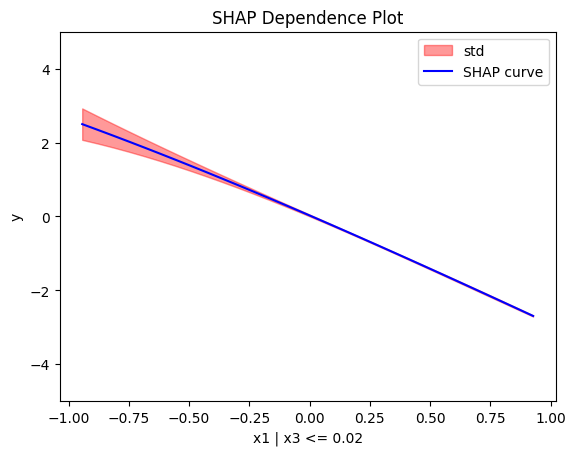

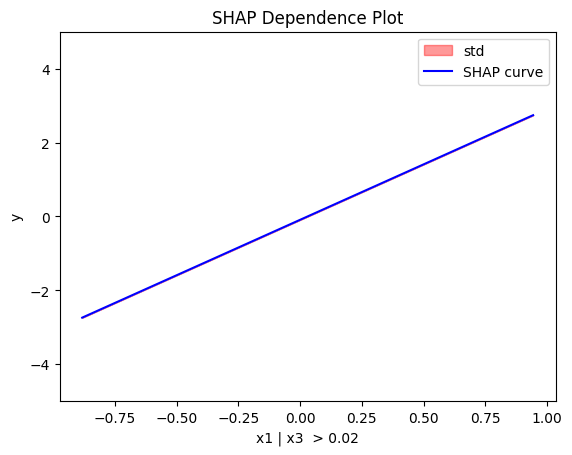

In [34]:
regional_shap.plot(feature=0, node_idx=1, heterogeneity="std", centering=True, y_limits=[-5, 5])
regional_shap.plot(feature=0, node_idx=2, heterogeneity="std", centering=True, y_limits=[-5, 5])

In [35]:
regional_shap.show_partitioning(features=1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.00 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.00


In [36]:
regional_shap.show_partitioning(features=2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.75 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.75


#### Conclusion

Global SHAP-DP:

   * the average effect of $x_1$ is $0$ with some heterogeneity implied by the interaction with $x_1$. The heterogeneity is expressed with two opposite lines; $-3x_1$ when $x_1 \leq 0$ and $3x_1$ when $x_1 >0$
   * the average effect of $x_2$ to be $0$ without heterogeneity
   * the average effect of $x_3$ to be $x_3$ with some heterogeneity due to the interaction with $x_1$. In contrast with other methods, SHAP spread the heterogeneity along the x-axis.
  
Regional SHAP-DP:


### Correlated setting

#### Global SHAP-DP

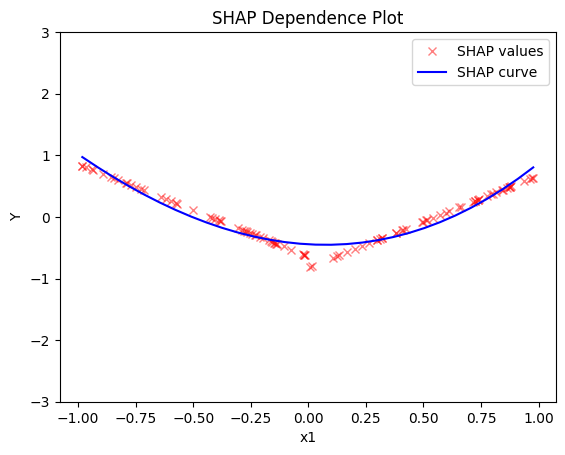

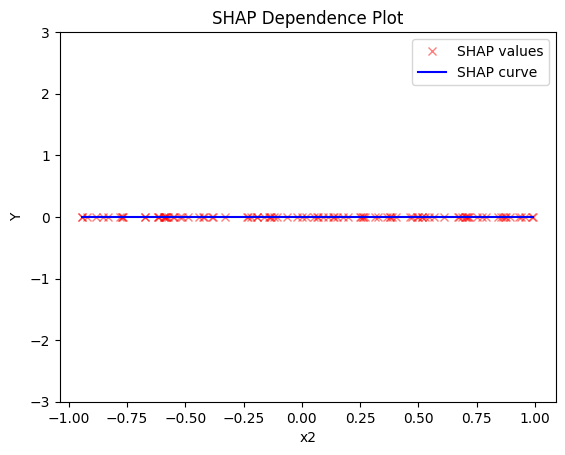

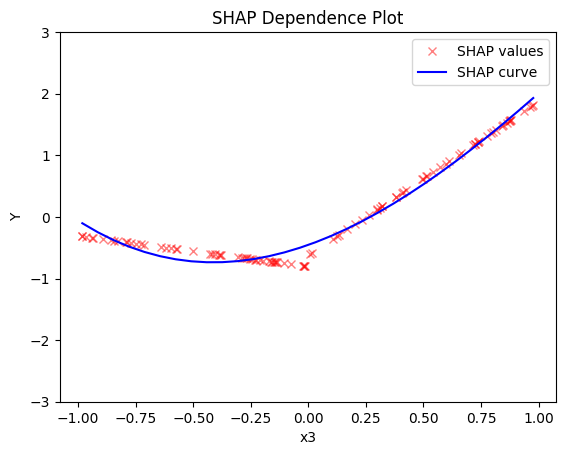

In [37]:
shap = effector.SHAPDependence(data=X_cor_train, model=model, feature_names=['x1','x2','x3'], target_name="Y")

shap.plot(feature=0, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=1, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])
shap.plot(feature=2, centering=True, heterogeneity="shap_values", show_avg_output=False, y_limits=[-3, 3])

#### Regional SHAP

In [38]:
regional_shap = effector.RegionalSHAP(
    data=X_cor_train, 
    model=model, 
    feature_names=['x1', 'x2', 'x3'],
    axis_limits=np.array([[-1, 1], [-1, 1], [-1, 1]]).T) 

regional_shap.fit(
    features="all",
    heter_pcg_drop_thres=0.6,
    nof_candidate_splits_for_numerical=11
)

100%|██████████| 3/3 [00:05<00:00,  1.77s/it]


In [39]:
regional_shap.show_partitioning(0)

Feature 0 - Full partition tree:
Node id: 0, name: x1, heter: 0.09 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 0 - Statistics per tree level:
Level 0, heter: 0.09


In [40]:
regional_shap.show_partitioning(1)

Feature 1 - Full partition tree:
Node id: 0, name: x2, heter: 0.00 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 1 - Statistics per tree level:
Level 0, heter: 0.00


In [41]:
regional_shap.show_partitioning(2)

Feature 2 - Full partition tree:
Node id: 0, name: x3, heter: 0.09 || nof_instances:   100 || weight: 1.00
--------------------------------------------------
Feature 2 - Statistics per tree level:
Level 0, heter: 0.09


#### Conclusion

